In [ ]:
import re
import nltk

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

Эimport pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## 1. Классификация фамилий (RNN)

Датасет: https://disk.yandex.ru/d/frNchuaBQVLxyA?w=1

1.1 Используя класс `nn.RNNCell` (абстракцию для отдельного временного шага RNN), реализуйте простейшую рекуррентную сеть Элмана в виде класса `RNN`. Используя созданный класс `RNN`, решите задачу классификации фамилий.


Этот класс RNN представляет собой простую однослойную рекуррентную нейронную сеть (RNN) с использованием ячейки nn.RNNCell. RNN предназначена для обработки последовательности данных, где x представляет собой входные данные размерности (batch_size, seq_len, feature_size). Каждый элемент последовательности обрабатывается на каждом временном шаге, и скрытое состояние обновляется. Модель возвращает тензор всех скрытых состояний

In [ ]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)

    def forward(self, x, h=None):
        """
        x.shape = (batch_size, seq_len, feature_size) - тензор входных данных
        h.shape = (batch_size, hidden_size) - тензор со скрытым состоянием RNN
        """

        batch_size, seq_len, _ = x.size()
        x = x.permute(1, 0, 2)

        if h is None:
            h = torch.zeros(batch_size, self.hidden_size, dtype=x.dtype, device=x.device)

        hidden_states = []

        # проход по каждому элементу последовательностей s в батче и обновление скрытого состояния
        for t in range(seq_len):
            h = self.rnn_cell(x[t], h)
            hidden_states.append(h)

        hidden_states = torch.stack(hidden_states)
        hidden_states = hidden_states.permute(1, 0, 2)

        return hidden_states

In [ ]:
import pandas as pd
df_surnames = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/surnames.csv')

class Vocab:
    def __init__(self, data):
        self.idx_to_token, self.token_to_idx = self.build_vocab(data)
        self.vocab_len = len(self.idx_to_token)
        self.max_seq_len = self.calculate_max_seq_len(data)

    def build_vocab(self, data):
        tokens = set()
        tokens.add('<PAD>')

        for surname in data:
            tokens.update(surname.lower())

        idx_to_token = {idx: token for idx, token in enumerate(tokens, start=0)}
        token_to_idx = {token: idx for idx, token in enumerate(tokens, start=0)}

        return idx_to_token, token_to_idx

    def calculate_max_seq_len(self, data):
        return max(len(surname) for surname in data)

In [ ]:
from torch.utils.data import Dataset

class SurnamesDataset(Dataset):
    def __init__(self, X, y, vocab: Vocab):
        self.X = X
        self.y = y
        self.vocab = vocab

    def vectorize(self, surname):
        indices = [self.vocab.token_to_idx.get(char, 0) for char in surname.lower()]

        while len(indices) < self.vocab.max_seq_len:
            indices.append(self.vocab.token_to_idx['<PAD>'])

        return indices[:self.vocab.max_seq_len]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        surname = self.X.iloc[idx]
        nationality = self.y.iloc[idx]

        vectorized_surname = self.vectorize(surname)
        target = nationality

        return {'surname': torch.tensor(vectorized_surname,  dtype=torch.long), 'target':torch.tensor(target, dtype=torch.long)}

In [ ]:
nationality_to_idx = {nationality: idx for idx, nationality in enumerate(df_surnames['nationality'].unique())}
idx_to_nationality = {idx: nationality for idx, nationality in enumerate(df_surnames['nationality'].unique())}
df_surnames['nationality'] = df_surnames['nationality'].map(nationality_to_idx)

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_surnames, test_size=0.2, random_state=42)
vocab = Vocab(df_surnames['surname'])
train_dataset = SurnamesDataset(X=train_df['surname'], y=train_df['nationality'], vocab=vocab)
test_dataset = SurnamesDataset(X=test_df['surname'], y=test_df['nationality'], vocab=vocab)

In [ ]:
def train(model, train_dl, optimizer, criterion):
    model.train()

    total_loss = 0.0
    total_samples = 0.0
    correct_samples = 0.0

    for batch in train_dl:
        inputs, targets = batch['surname'], batch['target']

        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss
        total_samples += targets.shape[0]

        _, prediction_indices = torch.max(outputs, 1)
        correct_samples += torch.sum(prediction_indices == targets)

    train_accuracy = float(correct_samples) / total_samples

    return total_loss, train_accuracy

def test(model, test_dl):
    model.eval()

    total_loss = 0.0
    total_samples = 0.0
    correct_samples = 0.0

    with torch.no_grad():
      for batch in test_dl:
          inputs, targets = batch['surname'], batch['target']

          outputs = model(inputs)
          loss = criterion(outputs, targets.squeeze())
          total_loss += loss


          total_samples += targets.shape[0]
          _, predictions_indices = torch.max(outputs, 1)
          correct_samples += torch.sum(predictions_indices==targets)

    test_accuracy = correct_samples / total_samples

    return total_loss, test_accuracy

In [ ]:
class SurnameClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, dropout_rate=0.5):
        super(SurnameClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = RNN(embedding_dim, hidden_size)
        self.h = None
        self.fc1 = nn.Linear(hidden_size, output_size)
        # self.fc2 = nn.Linear(hidden_size // 8, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.embedding(x)
        x = self.rnn(x, self.h)
        x = x[:, -1, :]
        x = self.fc1(x)
        # x = F.relu(x)
        # x = self.fc2(x)
        return x


batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

vocab_size = vocab.vocab_len
max_seq_len = vocab.max_seq_len
embedding_dim = 25
hidden_size = 128
output_size = len(nationality_to_idx)
# Устанавливаем freeze_embedding в True, чтобы эмбеддинг не обучался
model_1_1 = SurnameClassifier(vocab_size, embedding_dim, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1_1.parameters(), lr=0.008)

In [ ]:
max_seq_len

17

In [ ]:
%%time
losses_train, losses_test = [], []
for epoch in range(30):
    total_loss_train, train_accuracy = train(model_1_1, train_loader, optimizer, criterion)
    losses_train.append(total_loss_train.item())
    total_loss_test, test_accuracy = test(model_1_1, test_loader)
    losses_test.append(total_loss_test.item())

    print(f"epoch [{epoch+1}]: Train Loss: [{total_loss_train:.4f}], Train_acc: [{train_accuracy:.4f}],"
                            f" Test Loss: [{total_loss_test:.4f}], Test_acc: [{test_accuracy:.4f}]")

epoch [1]: Train Loss: [158.0741], Train_acc: [0.2490], Test Loss: [40.5288], Test_acc: [0.2140]
epoch [2]: Train Loss: [157.1440], Train_acc: [0.2464], Test Loss: [40.4462], Test_acc: [0.2687]
epoch [3]: Train Loss: [157.3298], Train_acc: [0.2506], Test Loss: [41.0370], Test_acc: [0.1448]
epoch [4]: Train Loss: [156.3863], Train_acc: [0.2509], Test Loss: [40.5586], Test_acc: [0.2687]
epoch [5]: Train Loss: [156.6301], Train_acc: [0.2568], Test Loss: [40.6278], Test_acc: [0.2687]
epoch [6]: Train Loss: [155.8055], Train_acc: [0.2511], Test Loss: [40.3415], Test_acc: [0.2687]
epoch [7]: Train Loss: [155.7303], Train_acc: [0.2605], Test Loss: [40.4591], Test_acc: [0.2837]
epoch [8]: Train Loss: [153.2867], Train_acc: [0.3013], Test Loss: [38.7414], Test_acc: [0.3238]
epoch [9]: Train Loss: [152.0860], Train_acc: [0.3157], Test Loss: [39.5298], Test_acc: [0.2801]
epoch [10]: Train Loss: [149.4493], Train_acc: [0.3193], Test Loss: [38.6054], Test_acc: [0.3156]
epoch [11]: Train Loss: [147.

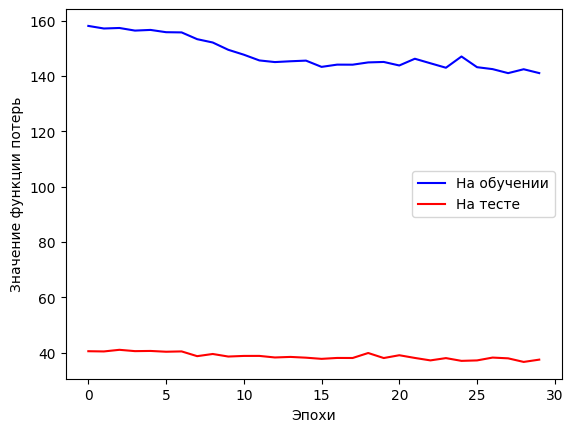

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses_train, label='На обучении', color='blue')
plt.plot(losses_test, label='На тесте', color='red')
plt.legend()
plt.xlabel('Эпохи')
plt.ylabel('Значение функции потерь')
plt.show()

In [ ]:
def vectorize(surname):
    indices = [vocab.token_to_idx.get(char, 0) for char in surname.lower()]

    while len(indices) < vocab.max_seq_len:
        indices.append(vocab.token_to_idx['<PAD>'])

    return torch.tensor(indices[:vocab.max_seq_len], dtype=torch.long).view(1, -1)


In [ ]:
import torch.nn.functional as F

def predict(model, input_surnames):
  for input_surname in input_surnames:
      vec_input_surname = vectorize(input_surname)
      input_tensor = vec_input_surname
      print(f'Фамилия: {input_surname}')

      with torch.no_grad():
          model.eval()
          outputs = model(input_tensor)
          res = F.softmax(outputs, dim=1)
          predictions = sorted(zip(list(nationality_to_idx.keys()), res.flatten()), key=lambda x: x[1], reverse=True)[:3]
          for country, prob in predictions:
            print(f'Страна: {country}, Вероятность: {prob.item() * 100:.4f}%')
          print()

input_surnames = ["paramonov", "perov"]
predict(model_1_1, input_surnames)

Фамилия: paramonov
Страна: Russian, Вероятность: 81.0540%
Страна: Italian, Вероятность: 3.7530%
Страна: Polish, Вероятность: 3.7378%

Фамилия: perov
Страна: English, Вероятность: 42.9171%
Страна: Russian, Вероятность: 15.6034%
Страна: Italian, Вероятность: 8.8110%



1.2 Замените модуль `RNN` из 1.1 на модули `nn.RNN`, `nn.LSTM` и `nn.GRU` (не забудьте указать аргумент `batch_first=True`). Сравните результаты работы.

In [ ]:
class SurnameClassifier2(nn.Module):
    def __init__(self, module, vocab_size, embedding_dim, hidden_size, output_size, dropout_rate=0.5):
        super(SurnameClassifier2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.h = None
        self.rnn = module(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, output_size)
        # self.fc2 = nn.Linear(hidden_size // 8, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.embedding(x)
        x, h = self.rnn(x, self.h)
        x = x[:, -1, :]
        x = self.fc1(x)
        # x = F.relu(x)
        # x = self.fc2(x)
        return x

**nn.RNN**

Рекуррентные слои (Recurrent Layers): Эти слои обрабатывают входные данные пошагово, сохраняя внутреннее состояние между шагами. Это позволяет модели учитывать контекст предыдущих входных данных при обработке текущего входа.

Внутреннее состояние (Hidden State): Это внутреннее представление, которое модель поддерживает между входами. Оно содержит информацию о предыдущих шагах и передается следующему шагу для учета контекста.

На вход:
 - input_size: Размер входных данных на каждом временном шаге.

 - hidden_size: Размер скрытого состояния.

 - num_layers: Количество слоев в RNN. (по умолчанию 1)

На выходе:
 - output: Тензор с выходными данными на каждом временном шаге для каждого элемента батча.
 - new_hidden_state: Последнее скрытое состояние после обработки последнего временного шага.

 batch_first = True означает что в тензоре входые данных размерность батча будет первой

В обычных RNN информация может быстро забываться или "размываться" в процессе передачи через множество временных шагов, известное как проблема затухающего градиента (vanishing gradient problem). Это может затруднить обучение модели учитывать долгосрочные зависимости.

In [ ]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

vocab_size = vocab.vocab_len
embedding_dim = 25
hidden_size = 128
output_size = len(nationality_to_idx)
model_1_2_rnn = SurnameClassifier2(nn.RNN, vocab_size, embedding_dim, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1_2_rnn.parameters(), lr=0.008)

In [ ]:
%%time
losses_train, losses_test = [], []
for epoch in range(30):
    total_loss_train, train_accuracy = train(model_1_2_rnn, train_loader, optimizer, criterion)
    losses_train.append(total_loss_train.item())
    total_loss_test, test_accuracy = test(model_1_2_rnn, test_loader)
    losses_test.append(total_loss_test.item())

    print(f"epoch [{epoch+1}]: Train Loss: [{total_loss_train:.4f}], Train_acc: [{train_accuracy:.4f}],"
                            f" Test Loss: [{total_loss_test:.4f}], Test_acc: [{test_accuracy:.4f}]")

epoch [1]: Train Loss: [159.6864], Train_acc: [0.2526], Test Loss: [40.3417], Test_acc: [0.2687]
epoch [2]: Train Loss: [156.6506], Train_acc: [0.2737], Test Loss: [41.3075], Test_acc: [0.2691]
epoch [3]: Train Loss: [155.6695], Train_acc: [0.2791], Test Loss: [40.6017], Test_acc: [0.3238]
epoch [4]: Train Loss: [156.4996], Train_acc: [0.2689], Test Loss: [40.0941], Test_acc: [0.2855]
epoch [5]: Train Loss: [152.0583], Train_acc: [0.3189], Test Loss: [37.3780], Test_acc: [0.3693]
epoch [6]: Train Loss: [145.9227], Train_acc: [0.3643], Test Loss: [37.9186], Test_acc: [0.3716]
epoch [7]: Train Loss: [141.5801], Train_acc: [0.3887], Test Loss: [37.1488], Test_acc: [0.3889]
epoch [8]: Train Loss: [141.9906], Train_acc: [0.3848], Test Loss: [38.3351], Test_acc: [0.3356]
epoch [9]: Train Loss: [141.1739], Train_acc: [0.3818], Test Loss: [36.3197], Test_acc: [0.3907]
epoch [10]: Train Loss: [142.0874], Train_acc: [0.3833], Test Loss: [37.7711], Test_acc: [0.3839]
epoch [11]: Train Loss: [143.

In [ ]:
input_surnames = ["paramonov", "perov"]
predict(model_1_2_rnn, input_surnames)

Фамилия: paramonov
Страна: Russian, Вероятность: 93.0345%
Страна: Greek, Вероятность: 2.7456%
Страна: Czech, Вероятность: 1.2471%

Фамилия: perov
Страна: Russian, Вероятность: 44.8358%
Страна: English, Вероятность: 16.7390%
Страна: Greek, Вероятность: 7.2187%



**nn.LSTM**

nn.LSTM в библиотеке PyTorch представляет собой рекуррентный слой, реализующий Long Short-Term Memory (LSTM) архитектуру. LSTM является одним из видов рекуррентных нейронных сетей (RNN), предназначенных для работы с последовательными данными, сохраняя информацию о контексте на протяжении времени.

Основные компоненты LSTM включают в себя:

 - Ячейка памяти (Memory Cell): Это место, где модель хранит и обновляет информацию о предыдущих состояниях.

 - Вентили (Gates): LSTM использует три вентиля - вентиль забывания (Forget Gate), вентиль ввода (Input Gate) и вентиль вывода (Output Gate). Эти вентили контролируют, какая информация должна быть забыта, какая информация должна быть добавлена в ячейку памяти и какая информация должна быть выходом модели.

 - Скрытое состояние (Hidden State): Это состояние передается от одного временного шага к следующему, и оно представляет собой краткое представление информации о прошлых состояниях.

LSTM обеспечивают механизм управления памятью, что делает их более способными к обработке долгосрочных зависимостей и решению проблемы затухающего градиента, которая может возникнуть при использовании обычных RNN.

In [ ]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

vocab_size = vocab.vocab_len
embedding_dim = 25
hidden_size = 128
output_size = len(nationality_to_idx)
model_1_2_lstm = SurnameClassifier2(nn.LSTM, vocab_size, embedding_dim, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1_2_lstm.parameters(), lr=0.008)

In [ ]:
%%time
losses_train, losses_test = [], []
for epoch in range(30):
    total_loss_train, train_accuracy = train(model_1_2_lstm, train_loader, optimizer, criterion)
    losses_train.append(total_loss_train.item())
    total_loss_test, test_accuracy = test(model_1_2_lstm, test_loader)
    losses_test.append(total_loss_test.item())

    print(f"epoch [{epoch+1}]: Train Loss: [{total_loss_train:.4f}], Train_acc: [{train_accuracy:.4f}],"
                            f" Test Loss: [{total_loss_test:.4f}], Test_acc: [{test_accuracy:.4f}]")

epoch [1]: Train Loss: [155.6054], Train_acc: [0.2560], Test Loss: [39.8311], Test_acc: [0.2687]
epoch [2]: Train Loss: [145.4001], Train_acc: [0.3444], Test Loss: [35.0008], Test_acc: [0.4308]
epoch [3]: Train Loss: [119.4304], Train_acc: [0.5237], Test Loss: [27.7306], Test_acc: [0.5883]
epoch [4]: Train Loss: [93.7524], Train_acc: [0.6322], Test Loss: [22.4194], Test_acc: [0.6639]
epoch [5]: Train Loss: [75.8946], Train_acc: [0.6926], Test Loss: [19.7598], Test_acc: [0.6899]
epoch [6]: Train Loss: [64.7585], Train_acc: [0.7286], Test Loss: [18.3019], Test_acc: [0.7131]
epoch [7]: Train Loss: [56.6879], Train_acc: [0.7541], Test Loss: [17.1289], Test_acc: [0.7250]
epoch [8]: Train Loss: [50.8942], Train_acc: [0.7757], Test Loss: [17.1503], Test_acc: [0.7222]
epoch [9]: Train Loss: [46.8289], Train_acc: [0.7909], Test Loss: [17.2698], Test_acc: [0.7327]
epoch [10]: Train Loss: [40.8528], Train_acc: [0.8176], Test Loss: [16.8025], Test_acc: [0.7336]
epoch [11]: Train Loss: [40.1168], T

In [ ]:
input_surnames = ["paramonov", "perov"]
predict(model_1_2_lstm, input_surnames)

Фамилия: paramonov
Страна: Russian, Вероятность: 99.9997%
Страна: Chinese, Вероятность: 0.0002%
Страна: Japanese, Вероятность: 0.0001%

Фамилия: perov
Страна: Russian, Вероятность: 99.9998%
Страна: Japanese, Вероятность: 0.0001%
Страна: Greek, Вероятность: 0.0000%



**nn.GRU**

nn.GRU в библиотеке PyTorch представляет собой ещё один тип рекуррентного слоя, реализующий архитектуру Gated Recurrent Unit (GRU). GRU является альтернативой LSTM и также предназначен для работы с последовательными данными, но с более простой архитектурой.

Основные компоненты nn.GRU включают в себя:

 - Скрытое состояние (Hidden State): Передается от одного временного шага к следующему, представляя краткое представление информации о прошлых состояниях.

 - Вентиль обновления (Update Gate): Определяет, какая часть информации из предыдущего скрытого состояния должна быть обновлена.

 - Вентиль сброса (Reset Gate): Определяет, какая часть информации из предыдущего скрытого состояния следует быть забыта.

GRU проще по структуре по сравнению с LSTM, так как она объединяет вентили обновления и сброса в один вентиль. Это делает GRU более легким для обучения и менее подверженным затуханию градиента в сравнении с некоторыми типами обычных RNN.

In [ ]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

vocab_size = vocab.vocab_len
embedding_dim = 25
hidden_size = 128
output_size = len(nationality_to_idx)
model_1_2_gru = SurnameClassifier2(nn.GRU, vocab_size, embedding_dim, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1_2_gru.parameters(), lr=0.008)

In [ ]:
%%time
losses_train, losses_test = [], []
for epoch in range(30):
    total_loss_train, train_accuracy = train(model_1_2_gru, train_loader, optimizer, criterion)
    losses_train.append(total_loss_train.item())
    total_loss_test, test_accuracy = test(model_1_2_gru, test_loader)
    losses_test.append(total_loss_test.item())

    print(f"epoch [{epoch+1}]: Train Loss: [{total_loss_train:.4f}], Train_acc: [{train_accuracy:.4f}],"
                            f" Test Loss: [{total_loss_test:.4f}], Test_acc: [{test_accuracy:.4f}]")

epoch [1]: Train Loss: [118.9446], Train_acc: [0.5010], Test Loss: [24.5702], Test_acc: [0.5938]
epoch [2]: Train Loss: [74.1069], Train_acc: [0.6883], Test Loss: [18.3122], Test_acc: [0.7186]
epoch [3]: Train Loss: [58.9592], Train_acc: [0.7458], Test Loss: [17.0417], Test_acc: [0.7222]
epoch [4]: Train Loss: [48.0340], Train_acc: [0.7820], Test Loss: [16.2727], Test_acc: [0.7382]
epoch [5]: Train Loss: [41.1333], Train_acc: [0.8158], Test Loss: [15.9178], Test_acc: [0.7541]
epoch [6]: Train Loss: [34.9128], Train_acc: [0.8396], Test Loss: [16.5321], Test_acc: [0.7532]
epoch [7]: Train Loss: [31.2479], Train_acc: [0.8510], Test Loss: [16.7204], Test_acc: [0.7523]
epoch [8]: Train Loss: [27.4938], Train_acc: [0.8678], Test Loss: [16.7335], Test_acc: [0.7523]
epoch [9]: Train Loss: [23.2186], Train_acc: [0.8897], Test Loss: [16.8178], Test_acc: [0.7564]
epoch [10]: Train Loss: [21.5490], Train_acc: [0.8959], Test Loss: [17.3767], Test_acc: [0.7454]
epoch [11]: Train Loss: [19.7279], Tra

In [ ]:
input_surnames = ["paramonov", "perov"]
predict(model_1_2_gru, input_surnames)

Фамилия: paramonov
Страна: Russian, Вероятность: 99.9882%
Страна: Czech, Вероятность: 0.0095%
Страна: Spanish, Вероятность: 0.0008%

Фамилия: perov
Страна: Russian, Вероятность: 99.9679%
Страна: English, Вероятность: 0.0251%
Страна: Czech, Вероятность: 0.0048%



**1. Структура и вентили:**

RNN:

 - Простая структура с обратной связью между временными шагами.
 - Нет явных вентилей для контроля потока информации.

LSTM:

 - Три вентиля: вентиль забывания, вентиль ввода и вентиль вывода.
 - Возможность эффективно управлять памятью и обрабатывать долгосрочные зависимости.

GRU:

 - Один вентиль, объединяющий вентили обновления и сброса.
 - Более простая структура по сравнению с LSTM.

**2. Число параметров:**

RNN:

 - Обычно содержит меньше параметров по сравнению с LSTM и GRU.

LSTM:

 - Обычно имеет больше параметров из-за наличия трех вентилей.

GRU:

 - Требует меньше параметров, что может быть преимуществом при ограниченных вычислительных ресурсах.

**3. Обучение:**

RNN:

 - Может сталкиваться с проблемой затухания градиента при обучении на длинных последовательностях.

LSTM:

 - Хорошо справляется с проблемой затухания градиента и обучается лучше на долгосрочных зависимостях.

GRU:

 - Обучается быстрее, чем LSTM, и также менее подвержен проблемам затухания градиента.

**4. Выбор в зависимости от задачи:**

RNN:

 - Простота и низкое количество параметров могут быть важными в определенных сценариях.

LSTM:

 - Хорошо подходит для задач, где важны долгосрочные зависимости, такие как обработка естественного языка (NLP).

GRU:

 - Может быть предпочтителен, если вы сталкиваетесь с ограниченными вычислительными ресурсами и хотите простую модель.

1.3 Загрузите предобученные эмбеддинги (https://disk.yandex.ru/d/BHuT2tEXr_yBOQ?w=1) в модуль `nn.Embedding` и обучите модели из 1.2.

In [ ]:
class SurnameClassifier3(nn.Module):
    def __init__(self, module, vocab_size, embedding_dim, hidden_size, output_size, vectors, dropout_rate=0.5):
        super(SurnameClassifier3, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vectors, freeze=True)
        self.h = None
        self.rnn = module(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, output_size)
        # self.fc2 = nn.Linear(hidden_size // 8, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.embedding(x)
        x, h = self.rnn(x, self.h)
        x = x[:, -1, :]
        x = self.fc1(x)
        # x = F.relu(x)
        # x = self.fc2(x)
        return x

In [ ]:
from gensim.models import KeyedVectors

file_path = '/content/drive/MyDrive/Colab Notebooks/globe_100_rows.txt'

word_vectors = {}

with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.split()
        word = parts[0]
        vector = [float(val) for val in parts[1:]]
        word_vectors[word] = vector

words = list(word_vectors.keys())
vectors = torch.FloatTensor(list(word_vectors.values()))
embedding_matrix = nn.Embedding.from_pretrained(vectors, freeze=True)

In [ ]:
words

['the',
 ',',
 '.',
 'of',
 'to',
 'and',
 'in',
 'a',
 '"',
 "'s",
 'for',
 '-',
 'that',
 'on',
 'is',
 'was',
 'said',
 'with',
 'he',
 'as',
 'it',
 'by',
 'at',
 '(',
 ')',
 'from',
 'his',
 "''",
 '``',
 'an',
 'be',
 'has',
 'are',
 'have',
 'but',
 'were',
 'not',
 'this',
 'who',
 'they',
 'had',
 'i',
 'which',
 'will',
 'their',
 ':',
 'or',
 'its',
 'one',
 'after',
 'new',
 'been',
 'also',
 'we',
 'would',
 'two',
 'more',
 "'",
 'first',
 'about',
 'up',
 'when',
 'year',
 'there',
 'all',
 '--',
 'out',
 'she',
 'other',
 'people',
 "n't",
 'her',
 'percent',
 'than',
 'over',
 'into',
 'last',
 'some',
 'government',
 'time',
 '$',
 'you',
 'years',
 'if',
 'no',
 'world',
 'can',
 'three',
 'do',
 ';',
 'president',
 'only',
 'state',
 'million',
 'could',
 'us',
 'most',
 '_',
 'against',
 'u.s.']

In [ ]:
vectors

tensor([[ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858],
        [ 0.0134,  0.2368, -0.1690,  ..., -0.5666,  0.0447,  0.3039],
        [ 0.1516,  0.3018, -0.1676,  ..., -0.3565,  0.0164,  0.1022],
        ...,
        [ 0.1499,  0.7318,  0.4202,  ..., -0.1501, -0.4110,  0.3928],
        [-0.6126, -0.8110, -0.1843,  ...,  0.0140,  0.1737, -0.6768],
        [-0.2805, -0.0832,  1.0143,  ...,  0.8242, -0.7768,  0.6647]])

**nn.RNN**

In [ ]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

vocab_size, embedding_dim = embedding_matrix.num_embeddings, embedding_matrix.embedding_dim

hidden_size = 128
output_size = len(nationality_to_idx)
model_1_3_rnn = SurnameClassifier3(nn.RNN, vocab_size, embedding_dim, hidden_size, output_size, vectors)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1_3_rnn.parameters(), lr=0.008)

In [ ]:
%%time
losses_train, losses_test = [], []
for epoch in range(30):
    total_loss_train, train_accuracy = train(model_1_3_rnn, train_loader, optimizer, criterion)
    losses_train.append(total_loss_train.item())
    total_loss_test, test_accuracy = test(model_1_3_rnn, test_loader)
    losses_test.append(total_loss_test.item())

    print(f"epoch [{epoch+1}]: Train Loss: [{total_loss_train:.4f}], Train_acc: [{train_accuracy:.4f}],"
                            f" Test Loss: [{total_loss_test:.4f}], Test_acc: [{test_accuracy:.4f}]")

epoch [1]: Train Loss: [157.5865], Train_acc: [0.2466], Test Loss: [41.0006], Test_acc: [0.2687]
epoch [2]: Train Loss: [156.7572], Train_acc: [0.2588], Test Loss: [40.4519], Test_acc: [0.2687]
epoch [3]: Train Loss: [156.8780], Train_acc: [0.2549], Test Loss: [41.1635], Test_acc: [0.1448]
epoch [4]: Train Loss: [157.6601], Train_acc: [0.2580], Test Loss: [41.1777], Test_acc: [0.2687]
epoch [5]: Train Loss: [156.9891], Train_acc: [0.2498], Test Loss: [40.2179], Test_acc: [0.2687]
epoch [6]: Train Loss: [156.6522], Train_acc: [0.2559], Test Loss: [40.4560], Test_acc: [0.2687]
epoch [7]: Train Loss: [155.8075], Train_acc: [0.2618], Test Loss: [40.4332], Test_acc: [0.2700]
epoch [8]: Train Loss: [155.2566], Train_acc: [0.2813], Test Loss: [40.7423], Test_acc: [0.2687]
epoch [9]: Train Loss: [157.3709], Train_acc: [0.2597], Test Loss: [40.5374], Test_acc: [0.2687]
epoch [10]: Train Loss: [156.4842], Train_acc: [0.2554], Test Loss: [40.5132], Test_acc: [0.2687]
epoch [11]: Train Loss: [157.

In [ ]:
input_surnames = ["paramonov", "perov"]
predict(model_1_3_rnn, input_surnames)

Фамилия: paramonov
Страна: English, Вероятность: 27.0973%
Страна: Arabic, Вероятность: 19.5020%
Страна: Russian, Вероятность: 19.0715%

Фамилия: perov
Страна: English, Вероятность: 27.0973%
Страна: Arabic, Вероятность: 19.5020%
Страна: Russian, Вероятность: 19.0715%



**nn.LSTM**

In [ ]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

vocab_size, embedding_dim = embedding_matrix.num_embeddings, embedding_matrix.embedding_dim

hidden_size = 128
output_size = len(nationality_to_idx)
model_1_3_lstm = SurnameClassifier3(nn.LSTM, vocab_size, embedding_dim, hidden_size, output_size, vectors)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1_3_lstm.parameters(), lr=0.008)

In [ ]:
%%time
losses_train, losses_test = [], []
for epoch in range(30):
    total_loss_train, train_accuracy = train(model_1_3_lstm, train_loader, optimizer, criterion)
    losses_train.append(total_loss_train.item())
    total_loss_test, test_accuracy = test(model_1_3_lstm, test_loader)
    losses_test.append(total_loss_test.item())

    print(f"epoch [{epoch+1}]: Train Loss: [{total_loss_train:.4f}], Train_acc: [{train_accuracy:.4f}],"
                            f" Test Loss: [{total_loss_test:.4f}], Test_acc: [{test_accuracy:.4f}]")

epoch [1]: Train Loss: [155.6605], Train_acc: [0.2622], Test Loss: [39.9990], Test_acc: [0.2687]
epoch [2]: Train Loss: [154.0252], Train_acc: [0.2712], Test Loss: [39.9263], Test_acc: [0.2687]
epoch [3]: Train Loss: [153.8765], Train_acc: [0.2712], Test Loss: [39.8668], Test_acc: [0.2687]
epoch [4]: Train Loss: [153.7522], Train_acc: [0.2712], Test Loss: [39.9412], Test_acc: [0.2687]
epoch [5]: Train Loss: [152.3537], Train_acc: [0.2895], Test Loss: [38.3266], Test_acc: [0.3420]
epoch [6]: Train Loss: [141.7351], Train_acc: [0.3923], Test Loss: [36.0055], Test_acc: [0.4071]
epoch [7]: Train Loss: [135.6088], Train_acc: [0.4214], Test Loss: [34.9978], Test_acc: [0.4176]
epoch [8]: Train Loss: [127.0452], Train_acc: [0.4629], Test Loss: [31.4875], Test_acc: [0.5337]
epoch [9]: Train Loss: [110.5685], Train_acc: [0.5639], Test Loss: [28.1971], Test_acc: [0.5861]
epoch [10]: Train Loss: [99.3015], Train_acc: [0.6108], Test Loss: [26.0477], Test_acc: [0.6052]
epoch [11]: Train Loss: [91.70

In [ ]:
input_surnames = ["paramonov", "perov"]
predict(model_1_3_lstm, input_surnames)

Фамилия: paramonov
Страна: Russian, Вероятность: 99.9159%
Страна: Italian, Вероятность: 0.0459%
Страна: Japanese, Вероятность: 0.0148%

Фамилия: perov
Страна: Russian, Вероятность: 99.9863%
Страна: Czech, Вероятность: 0.0131%
Страна: English, Вероятность: 0.0003%



In [ ]:
model_1_3_lstm.embedding.weight

Parameter containing:
tensor([[ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858],
        [ 0.0134,  0.2368, -0.1690,  ..., -0.5666,  0.0447,  0.3039],
        [ 0.1516,  0.3018, -0.1676,  ..., -0.3565,  0.0164,  0.1022],
        ...,
        [ 0.1499,  0.7318,  0.4202,  ..., -0.1501, -0.4110,  0.3928],
        [-0.6126, -0.8110, -0.1843,  ...,  0.0140,  0.1737, -0.6768],
        [-0.2805, -0.0832,  1.0143,  ...,  0.8242, -0.7768,  0.6647]])

**nn.GRU**

In [ ]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

vocab_size, embedding_dim = embedding_matrix.num_embeddings, embedding_matrix.embedding_dim

hidden_size = 128
output_size = len(nationality_to_idx)
model_1_3_gru = SurnameClassifier3(nn.GRU, vocab_size, embedding_dim, hidden_size, output_size, vectors)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1_3_gru.parameters(), lr=0.008)

In [ ]:
%%time
losses_train, losses_test = [], []
for epoch in range(30):
    total_loss_train, train_accuracy = train(model_1_3_gru, train_loader, optimizer, criterion)
    losses_train.append(total_loss_train.item())
    total_loss_test, test_accuracy = test(model_1_3_gru, test_loader)
    losses_test.append(total_loss_test.item())

    print(f"epoch [{epoch+1}]: Train Loss: [{total_loss_train:.4f}], Train_acc: [{train_accuracy:.4f}],"
                            f" Test Loss: [{total_loss_test:.4f}], Test_acc: [{test_accuracy:.4f}]")

epoch [1]: Train Loss: [142.0374], Train_acc: [0.3650], Test Loss: [30.5491], Test_acc: [0.5005]
epoch [2]: Train Loss: [96.3893], Train_acc: [0.6036], Test Loss: [21.0465], Test_acc: [0.6630]
epoch [3]: Train Loss: [69.5584], Train_acc: [0.7067], Test Loss: [18.1890], Test_acc: [0.7072]
epoch [4]: Train Loss: [58.4745], Train_acc: [0.7489], Test Loss: [16.9398], Test_acc: [0.7259]
epoch [5]: Train Loss: [50.1213], Train_acc: [0.7776], Test Loss: [16.9002], Test_acc: [0.7295]
epoch [6]: Train Loss: [43.8177], Train_acc: [0.8004], Test Loss: [16.1358], Test_acc: [0.7445]
epoch [7]: Train Loss: [38.7987], Train_acc: [0.8224], Test Loss: [16.3497], Test_acc: [0.7559]
epoch [8]: Train Loss: [34.8221], Train_acc: [0.8426], Test Loss: [17.3167], Test_acc: [0.7523]
epoch [9]: Train Loss: [30.7724], Train_acc: [0.8555], Test Loss: [16.9016], Test_acc: [0.7473]
epoch [10]: Train Loss: [28.1542], Train_acc: [0.8666], Test Loss: [18.7019], Test_acc: [0.7291]
epoch [11]: Train Loss: [26.5108], Tra

In [ ]:
input_surnames = ["paramonov", "perov"]
predict(model_1_3_gru, input_surnames)

Фамилия: paramonov
Страна: Russian, Вероятность: 99.9902%
Страна: English, Вероятность: 0.0092%
Страна: Czech, Вероятность: 0.0002%

Фамилия: perov
Страна: Russian, Вероятность: 97.0630%
Страна: Czech, Вероятность: 2.5622%
Страна: English, Вероятность: 0.2188%



**glove.6B.50d.txt**

In [ ]:
from gensim.models import KeyedVectors

file_path = '/content/drive/MyDrive/Colab Notebooks/glove.6B.50d.txt'

word_vectors = {}

with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.split()
        word = parts[0]
        vector = [float(val) for val in parts[1:]]
        word_vectors[word] = vector

words = list(word_vectors.keys())
vectors = torch.FloatTensor(list(word_vectors.values()))
embedding_matrix = nn.Embedding.from_pretrained(vectors, freeze=True)

In [ ]:
embedding_matrix

Embedding(400000, 50)

In [ ]:
vectors

tensor([[ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858],
        [ 0.0134,  0.2368, -0.1690,  ..., -0.5666,  0.0447,  0.3039],
        [ 0.1516,  0.3018, -0.1676,  ..., -0.3565,  0.0164,  0.1022],
        ...,
        [-0.5118,  0.0587,  1.0913,  ..., -0.2500, -1.1250,  1.5863],
        [-0.7590, -0.4743,  0.4737,  ...,  0.7895, -0.0141,  0.6448],
        [ 0.0726, -0.5139,  0.4728,  ..., -0.1891, -0.5902,  0.5556]])

**nn.RNN**

In [ ]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

vocab_size, embedding_dim = embedding_matrix.num_embeddings, embedding_matrix.embedding_dim

hidden_size = 128
output_size = len(nationality_to_idx)
model_1_3_rnn = SurnameClassifier3(nn.RNN, vocab_size, embedding_dim, hidden_size, output_size, vectors)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1_3_rnn.parameters(), lr=0.008)

In [ ]:
%%time
losses_train, losses_test = [], []
for epoch in range(30):
    total_loss_train, train_accuracy = train(model_1_3_rnn, train_loader, optimizer, criterion)
    losses_train.append(total_loss_train.item())
    total_loss_test, test_accuracy = test(model_1_3_rnn, test_loader)
    losses_test.append(total_loss_test.item())

    print(f"epoch [{epoch+1}]: Train Loss: [{total_loss_train:.4f}], Train_acc: [{train_accuracy:.4f}],"
                            f" Test Loss: [{total_loss_test:.4f}], Test_acc: [{test_accuracy:.4f}]")

epoch [1]: Train Loss: [158.7632], Train_acc: [0.2460], Test Loss: [40.7909], Test_acc: [0.2687]
epoch [2]: Train Loss: [157.2390], Train_acc: [0.2491], Test Loss: [40.8029], Test_acc: [0.2687]
epoch [3]: Train Loss: [157.0077], Train_acc: [0.2523], Test Loss: [40.7771], Test_acc: [0.2687]
epoch [4]: Train Loss: [156.2178], Train_acc: [0.2633], Test Loss: [40.2426], Test_acc: [0.2140]
epoch [5]: Train Loss: [156.2795], Train_acc: [0.2609], Test Loss: [41.0542], Test_acc: [0.2687]
epoch [6]: Train Loss: [157.4924], Train_acc: [0.2530], Test Loss: [40.4707], Test_acc: [0.2687]
epoch [7]: Train Loss: [158.3839], Train_acc: [0.2363], Test Loss: [40.2675], Test_acc: [0.2687]
epoch [8]: Train Loss: [157.9359], Train_acc: [0.2561], Test Loss: [40.6484], Test_acc: [0.2687]
epoch [9]: Train Loss: [156.5750], Train_acc: [0.2502], Test Loss: [40.5376], Test_acc: [0.2687]
epoch [10]: Train Loss: [157.3250], Train_acc: [0.2719], Test Loss: [40.5645], Test_acc: [0.2140]
epoch [11]: Train Loss: [157.

In [ ]:
input_surnames = ["paramonov", "perov"]
predict(model_1_3_rnn, input_surnames)

Фамилия: paramonov
Страна: English, Вероятность: 31.2288%
Страна: Russian, Вероятность: 23.9761%
Страна: Arabic, Вероятность: 17.3108%

Фамилия: perov
Страна: English, Вероятность: 31.2288%
Страна: Russian, Вероятность: 23.9761%
Страна: Arabic, Вероятность: 17.3108%



In [ ]:
model_1_3_rnn.embedding.weight

Parameter containing:
tensor([[ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858],
        [ 0.0134,  0.2368, -0.1690,  ..., -0.5666,  0.0447,  0.3039],
        [ 0.1516,  0.3018, -0.1676,  ..., -0.3565,  0.0164,  0.1022],
        ...,
        [-0.5118,  0.0587,  1.0913,  ..., -0.2500, -1.1250,  1.5863],
        [-0.7590, -0.4743,  0.4737,  ...,  0.7895, -0.0141,  0.6448],
        [ 0.0726, -0.5139,  0.4728,  ..., -0.1891, -0.5902,  0.5556]])

**nn.LSTM**

In [ ]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

vocab_size, embedding_dim = embedding_matrix.num_embeddings, embedding_matrix.embedding_dim

hidden_size = 128
output_size = len(nationality_to_idx)
model_1_3_lstm = SurnameClassifier3(nn.LSTM, vocab_size, embedding_dim, hidden_size, output_size, vectors)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1_3_lstm.parameters(), lr=0.008)

In [ ]:
%%time
losses_train, losses_test = [], []
for epoch in range(30):
    total_loss_train, train_accuracy = train(model_1_3_lstm, train_loader, optimizer, criterion)
    losses_train.append(total_loss_train.item())
    total_loss_test, test_accuracy = test(model_1_3_lstm, test_loader)
    losses_test.append(total_loss_test.item())

    print(f"epoch [{epoch+1}]: Train Loss: [{total_loss_train:.4f}], Train_acc: [{train_accuracy:.4f}],"
                            f" Test Loss: [{total_loss_test:.4f}], Test_acc: [{test_accuracy:.4f}]")

epoch [1]: Train Loss: [155.3275], Train_acc: [0.2614], Test Loss: [39.9735], Test_acc: [0.2687]
epoch [2]: Train Loss: [154.0306], Train_acc: [0.2689], Test Loss: [40.0078], Test_acc: [0.2687]
epoch [3]: Train Loss: [153.9457], Train_acc: [0.2712], Test Loss: [39.9305], Test_acc: [0.2687]
epoch [4]: Train Loss: [153.7668], Train_acc: [0.2637], Test Loss: [39.9362], Test_acc: [0.2687]
epoch [5]: Train Loss: [153.7169], Train_acc: [0.2712], Test Loss: [39.8777], Test_acc: [0.2687]
epoch [6]: Train Loss: [153.7227], Train_acc: [0.2642], Test Loss: [39.9645], Test_acc: [0.2687]
epoch [7]: Train Loss: [153.7850], Train_acc: [0.2712], Test Loss: [39.7929], Test_acc: [0.2687]
epoch [8]: Train Loss: [153.5053], Train_acc: [0.2712], Test Loss: [39.8856], Test_acc: [0.2687]
epoch [9]: Train Loss: [153.5648], Train_acc: [0.2712], Test Loss: [39.9457], Test_acc: [0.2687]
epoch [10]: Train Loss: [153.5539], Train_acc: [0.2712], Test Loss: [39.8434], Test_acc: [0.2687]
epoch [11]: Train Loss: [153.

In [ ]:
input_surnames = ["paramonov", "perov"]
predict(model_1_3_lstm, input_surnames)

Фамилия: paramonov
Страна: Russian, Вероятность: 99.8016%
Страна: Polish, Вероятность: 0.0521%
Страна: Czech, Вероятность: 0.0481%

Фамилия: perov
Страна: Russian, Вероятность: 96.8486%
Страна: Czech, Вероятность: 1.6179%
Страна: English, Вероятность: 0.7476%



**nn.GRU**

In [ ]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

vocab_size, embedding_dim = embedding_matrix.num_embeddings, embedding_matrix.embedding_dim

hidden_size = 128
output_size = len(nationality_to_idx)
model_1_3_gru = SurnameClassifier3(nn.GRU, vocab_size, embedding_dim, hidden_size, output_size, vectors)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1_3_gru.parameters(), lr=0.008)

In [ ]:
%%time
losses_train, losses_test = [], []
for epoch in range(30):
    total_loss_train, train_accuracy = train(model_1_3_gru, train_loader, optimizer, criterion)
    losses_train.append(total_loss_train.item())
    total_loss_test, test_accuracy = test(model_1_3_gru, test_loader)
    losses_test.append(total_loss_test.item())

    print(f"epoch [{epoch+1}]: Train Loss: [{total_loss_train:.4f}], Train_acc: [{train_accuracy:.4f}],"
                            f" Test Loss: [{total_loss_test:.4f}], Test_acc: [{test_accuracy:.4f}]")

epoch [1]: Train Loss: [138.9185], Train_acc: [0.3856], Test Loss: [30.9273], Test_acc: [0.5027]
epoch [2]: Train Loss: [95.9503], Train_acc: [0.6006], Test Loss: [21.9414], Test_acc: [0.6571]
epoch [3]: Train Loss: [70.7707], Train_acc: [0.7075], Test Loss: [18.0926], Test_acc: [0.7117]
epoch [4]: Train Loss: [58.6510], Train_acc: [0.7474], Test Loss: [16.8484], Test_acc: [0.7254]
epoch [5]: Train Loss: [50.8670], Train_acc: [0.7771], Test Loss: [15.9615], Test_acc: [0.7354]
epoch [6]: Train Loss: [43.7036], Train_acc: [0.8045], Test Loss: [16.7434], Test_acc: [0.7259]
epoch [7]: Train Loss: [38.5307], Train_acc: [0.8230], Test Loss: [16.4002], Test_acc: [0.7532]
epoch [8]: Train Loss: [33.7461], Train_acc: [0.8490], Test Loss: [17.2785], Test_acc: [0.7423]
epoch [9]: Train Loss: [29.9178], Train_acc: [0.8582], Test Loss: [17.5472], Test_acc: [0.7368]
epoch [10]: Train Loss: [26.2582], Train_acc: [0.8763], Test Loss: [17.5898], Test_acc: [0.7263]
epoch [11]: Train Loss: [24.5920], Tra

In [ ]:
input_surnames = ["paramonov", "perov"]
predict(model_1_3_gru, input_surnames)

Фамилия: paramonov
Страна: Russian, Вероятность: 99.2991%
Страна: Czech, Вероятность: 0.6805%
Страна: Dutch, Вероятность: 0.0102%

Фамилия: perov
Страна: Russian, Вероятность: 99.8437%
Страна: English, Вероятность: 0.1247%
Страна: Czech, Вероятность: 0.0299%



## 2. Классификация обзоров на фильмы (RNN)

Датасет: https://disk.yandex.ru/d/tdinpb0nN_Dsrg

2.1 Создайте набор данных на основе файлов polarity/positive_reviews.csv (положительные отзывы) и polarity/negative_reviews.csv (отрицательные отзывы). Разбейте на обучающую и тестовую выборку.
  * токен = __слово__
  * данные для обучения в датасете представляются в виде последовательности индексов токенов
  * словарь создается на основе _только_ обучающей выборки. Для корректной обработки ситуаций, когда в тестовой выборке встретится токен, который не хранится в словаре, добавьте в словарь специальный токен `<UNK>`
  * добавьте предобработку текста

2.2. Обучите классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding`
    - подберите адекватную размерность вектора эмбеддинга:
    - модуль `nn.Embedding` обучается

  * Используйте рекуррентные слои (`nn.RNN`, `nn.LSTM`, `nn.GRU`)


2.3 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)
* Целевое значение accuracy на валидации - 70+%

In [ ]:
positive = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/positive_reviews.txt", sep='%-%', header=None, engine="python")
positive["type"] = "positive"

negative = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/negative_reviews.txt", sep='%-%', header=None, engine="python")
negative["type"] = "negative"

df_review = pd.concat([positive, negative], ignore_index=True)

df_review.columns = ["review", "type"]

In [ ]:
df_review['type'] = df_review['type'].replace({'positive': 1, 'negative': 0})

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z]', ' ', text)
    tokens = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    processed_text = ' '.join(tokens)

    return processed_text

df_review['review'] = df_review['review'].apply(preprocess_text)

df_review.head()

,review,type
0,simplistic silly and tedious,1
1,it s so laddish and juvenile only teenage boy ...,1
2,exploitative and largely devoid of the depth o...,1
3,garbus discard the potential for pathological ...,1
4,a visually flashy but narratively opaque and e...,1


In [ ]:
import nltk
from nltk.tokenize import word_tokenize

class Vocab:
    def __init__(self, data):
        self.idx_to_token, self.token_to_idx = self.build_vocab(data)
        self.vocab_len = len(self.idx_to_token)
        self.max_seq_len = self.calculate_max_seq_len(data)

    def build_vocab(self, data):
        tokens = set()
        tokens.add('<PAD>')
        tokens.add('<UNK>')

        for review in data:
            review_tokens = word_tokenize(review.lower())
            tokens.update(review_tokens)

        idx_to_token = {idx: token for idx, token in enumerate(tokens, start=0)}
        token_to_idx = {token: idx for idx, token in enumerate(tokens, start=0)}

        return idx_to_token, token_to_idx

    def calculate_max_seq_len(self, data):
        return max(len(word_tokenize(review.lower())) for review in data)

In [ ]:
from torch.utils.data import Dataset

class ReviewDataset(Dataset):
    def __init__(self, X, y, vocab: Vocab):
        self.X = X
        self.y = y
        self.vocab = vocab

    def vectorize(self, review):
        review = review.split()
        indices = [self.vocab.token_to_idx.get(word, self.vocab.token_to_idx['<UNK>']) for word in review]


        while len(indices) < self.vocab.max_seq_len:
            indices.append(self.vocab.token_to_idx['<PAD>'])

        return indices[:self.vocab.max_seq_len]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        review = self.X.iloc[idx]
        target = self.y.iloc[idx]

        vectorized_review = self.vectorize(review)

        return {'review': torch.tensor(vectorized_review,  dtype=torch.long), 'target':torch.tensor(target, dtype=torch.long)}

In [ ]:
train_df, test_df = train_test_split(df_review, test_size=0.2, random_state=42)

vocab = Vocab(df_review['review'])

train_dataset = ReviewDataset(X=train_df['review'], y=train_df['type'], vocab=vocab)
test_dataset = ReviewDataset(X=test_df['review'], y=test_df['type'], vocab=vocab)

In [ ]:
def vectorize(review):
        review = preprocess_text(review)
        review = review.split()
        indices = [vocab.token_to_idx.get(word, vocab.token_to_idx['<UNK>']) for word in review]

        while len(indices) < vocab.max_seq_len:
            indices.append(vocab.token_to_idx['<PAD>'])

        return indices[:vocab.max_seq_len]

In [ ]:
class ReviewClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, max_seq_len, num_layers=2, freeze_embedding=True, dropout_rate=0.5):
        super(ReviewClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.requires_grad = freeze_embedding

        self.rnn_lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.rnn_gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)

        lstm_out, _ = self.rnn_lstm(x.clone())
        lstm_out = lstm_out[:, -1, :]

        gru_out, _ = self.rnn_gru(x.clone())
        gru_out = gru_out[:, -1, :]

        # Объединение выходов
        combined_out = torch.cat([lstm_out, gru_out], dim=1)

        combined_out = self.relu(combined_out)
        combined_out = self.dropout(combined_out)

        output = self.relu(self.fc1(combined_out))
        output = self.fc2(output)

        return output

In [ ]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

vocab_size = vocab.vocab_len
max_seq_len = vocab.max_seq_len
embedding_dim = 150
hidden_size = 128
output_size = 2

model_3_1 = ReviewClassifier(vocab_size, embedding_dim, hidden_size, output_size, max_seq_len, freeze_embedding=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3_1.parameters(), lr=0.002)

In [ ]:
def train(model, train_dl, optimizer, criterion):
    model.train()

    total_loss = 0.0
    total_samples = 0.0
    correct_samples = 0.0

    for batch in train_dl:
        inputs, targets = batch['review'], batch['target']

        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss

        total_samples += targets.shape[0]

        _, prediction_indices = torch.max(outputs, 1)
        correct_samples += torch.sum(prediction_indices==targets)

    train_accuracy = float(correct_samples) / total_samples

    return total_loss, train_accuracy

def test(model, test_dl, criterion):
    model.eval()

    total_loss = 0.0
    total_samples = 0.0
    correct_samples = 0.0

    with torch.no_grad():
      for batch in test_dl:

          inputs, targets = batch['review'], batch['target']
          inp = inputs

          outputs = model(inputs)
          loss = criterion(outputs, targets.squeeze())
          total_loss += loss


          total_samples += targets.shape[0]
          _, predictions_indices = torch.max(outputs, 1)
          correct_samples += torch.sum(predictions_indices==targets)

    test_accuracy = correct_samples / total_samples

    return total_loss, test_accuracy

In [ ]:
total_params = sum(p.numel() for p in model_3_1.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 2982852


In [ ]:
losses_train, losses_test = [], []
for epoch in range(10):
    total_loss_train, train_accuracy = train(model_3_1, train_loader, optimizer, criterion)
    losses_train.append(total_loss_train.item())
    total_loss_test, test_accuracy = test(model_3_1, test_loader, criterion)
    losses_test.append(total_loss_test.item())

    print(f"epoch [{epoch+1}]: Train Loss: [{total_loss_train:.4f}], Train_acc: [{train_accuracy:.4f}],"
                            f" Test Loss: [{total_loss_test:.4f}], Test_acc: [{test_accuracy:.4f}]")

    if test_accuracy > 0.7:
        break

epoch [1]: Train Loss: [46.5835], Train_acc: [0.4988], Test Loss: [11.7845], Test_acc: [0.5021]
epoch [2]: Train Loss: [46.4640], Train_acc: [0.5008], Test Loss: [11.7012], Test_acc: [0.5963]
epoch [3]: Train Loss: [44.3054], Train_acc: [0.6165], Test Loss: [10.5756], Test_acc: [0.6507]
epoch [4]: Train Loss: [35.0559], Train_acc: [0.7595], Test Loss: [9.6578], Test_acc: [0.7117]


In [ ]:
def vectorize(review):
        review = preprocess_text(review)
        print(review)
        indices = [vocab.token_to_idx.get(word, vocab.token_to_idx['<UNK>']) for word in review]

        while len(indices) < vocab.max_seq_len:
            indices.append(vocab.token_to_idx['<PAD>'])

        return torch.tensor(indices[:vocab.max_seq_len], dtype=torch.long)

reviews = [
    "This movie exceeded all my expectations! The acting was brilliant, and the storyline kept me engaged from start to finish. A must-watch!",
    "An absolute masterpiece! The director's vision and the performances by the cast were outstanding. I was captivated throughout the entire film.",
    "I can't express how much I enjoyed this movie. The plot twists were unexpected, and the cinematography was stunning. Highly recommended!",

    "This film was a huge letdown. The plot was predictable, the characters were one-dimensional, and the acting was subpar. I regret spending my time and money on it.",
    "I wouldn't recommend this movie. The marketing promised an exciting adventure, but it turned out to be a dull story. The special effects were mediocre, and the dialogue was tasteless",
]

for input_review in reviews:
    vec_input_review = vectorize(input_review)
    input_tensor = vec_input_review.view(1, -1)

    with torch.no_grad():
        model_3_1.eval()
        outputs = model_3_1(input_tensor)
        _, predictions_indices = torch.max(outputs, 1)

    print(f'Отзыв: {input_review} \nКласс: {predictions_indices.item()}')

this movie exceeded all my expectation the acting wa brilliant and the storyline kept me engaged from start to finish a must watch
Отзыв: This movie exceeded all my expectations! The acting was brilliant, and the storyline kept me engaged from start to finish. A must-watch! 
Класс: 1
an absolute masterpiece the director s vision and the performance by the cast were outstanding i wa captivated throughout the entire film
Отзыв: An absolute masterpiece! The director's vision and the performances by the cast were outstanding. I was captivated throughout the entire film. 
Класс: 1
i can t express how much i enjoyed this movie the plot twist were unexpected and the cinematography wa stunning highly recommended
Отзыв: I can't express how much I enjoyed this movie. The plot twists were unexpected, and the cinematography was stunning. Highly recommended! 
Класс: 1
this film wa a huge letdown the plot wa predictable the character were one dimensional and the acting wa subpar i regret spending my